In [35]:
import torch
import nangs
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [33]:
# 定义参数
kappa = 1e-6  # 热扩散系数
T0 = 300  # 表面温度 (单位: K)
ql = 50  # 底部热流密度 (单位: W/m²)
kl = 2.5  # 热导率 (单位: W/m/K)
L = 1.0  # 深度范围 (单位: m)
time_max = 10.0  # 最大模拟时间 (单位: 年)

# 定义动态抬升率 e(t) 函数
def uplift_rate(t):
    """
    动态抬升率函数，例如：
    - 线性增长：e(t) = e0 + alpha * t
    """
    e0 = 0.1  # 初始抬升率 (单位: m/年)
    alpha = 0.01  # 增长率
    return e0 + alpha * t  # 线性增长

# 定义热传导方程 (PDE)
class HeatEquationDynamicUplift(nangs.PDE):

    def computePDELoss(self, inputs, outputs):
        e_t = uplift_rate(inputs[:,0])
        # compute first-order derivatives
        grads = self.computeGrads(outputs, inputs)       
        dTdt, dTdz = grads[:, 0], grads[:, 1]
        
        # compute second-order derivatives
        dT2dt2 = self.computeGrads(dTdt, inputs)[:, 0]        
        dT2dz2 = self.computeGrads(dTdz, inputs)[:, 1]
        return {'pde': dTdt - e_t * dTdz - kappa * dT2dz2}
        
# 创建一个采样器，用于生成训练数据
sampler = nangs.RandomSampler(
    {
        "t": [0, time_max],  # 时间范围
        "z": [0, L],  # 深度范围
    },
    device=device,
    n_samples=1000,
)

# # 定义边界条件
# # T|z=0 = T0
# def boundary_top(data):
#     return data["T"] - T0

# # ∂T/∂z|z=L = ql / kl
# def boundary_bottom(data):
#     dT_dz = torch.autograd.grad(data["T"], data["z"], create_graph=True)[0]
#     return dT_dz - ql / kl


# 初始化 PDE
pde = HeatEquationDynamicUplift(inputs=('t', 'z'), outputs='T')

# 条件1
initial_condition = nangs.Dirichlet(
    nangs.RandomSampler({'t': [0., time_max], 'z': 0.}, device=device, n_samples=1000), 
    lambda inputs: {'T' : torch.ones_like(inputs["z"]*T0)},
    name="initial"
)

class MyNeumann(nangs.Neumann):
    def computeBocoLoss(self, inputs, outputs):
        dTdz = self.computeGrads(outputs, inputs)[:, 1]
        return {'gradz': dTdz- ql / kl}

z_right = MyNeumann(
    nangs.RandomSampler({'t': [0.,time_max], 'z': L}, device=device, n_samples=1000), 
    name='z_right'
)

pde.set_sampler(sampler)
pde.add_boco(initial_condition)
pde.add_boco(z_right)

# 定义神经网络
NUM_LAYERS = 5
NUM_HIDDEN = 100
N_STEPS = 1000
LR = 3e-4
mlp = nangs.MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)

# 定义求解器
optimizer = torch.optim.Adam(mlp.parameters(), lr=LR)

# 训练神经网络
pde.compile(mlp, optimizer)
%time hist = pde.solve(N_STEPS, log_each=100)



/home/gaofei/local/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
{'pde': 0.6362, 'initial': 0.00676, 'z_right_gradz': 0.02883}: 100%|█| 1000/1000

CPU times: user 4.69 s, sys: 81.4 ms, total: 4.77 s
Wall time: 4.92 s


<Axes: >

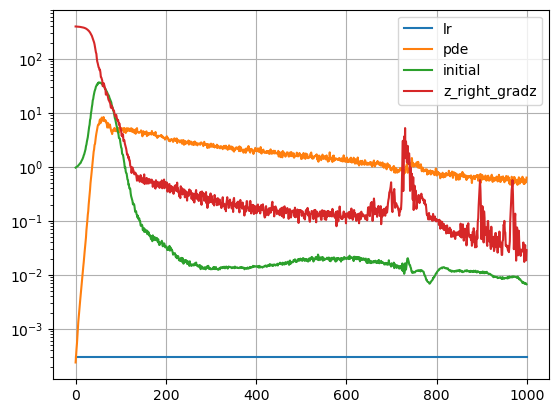

In [36]:
df = pd.DataFrame(hist)
fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
ax.set_yscale('log')
df.plot(ax=ax, grid=True)

In [48]:
np.meshgrid(t,z)

[array([[10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        ...,
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.]], dtype=float32),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.01010101, 0.01010101, 0.01010101, ..., 0.01010101, 0.01010101,
         0.01010101],
        [0.02020202, 0.02020202, 0.02020202, ..., 0.02020202, 0.02020202,
         0.02020202],
        ...,
        [0.97979796, 0.97979796, 0.97979796, ..., 0.97979796, 0.97979796,
         0.97979796],
        [0.989899  , 0.989899  , 0.989899  , ..., 0.989899  , 0.989899  ,
         0.989899  ],
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ]], dtype=float32)]

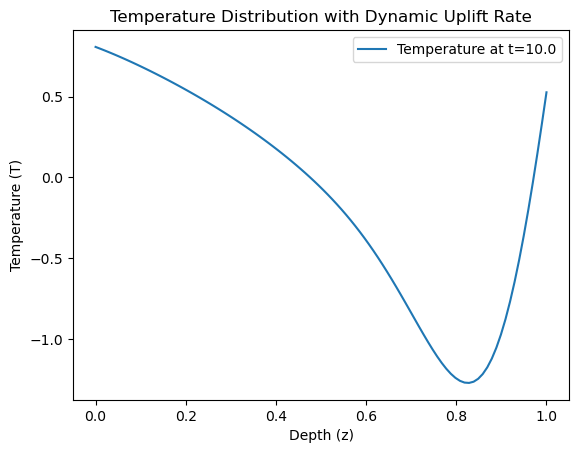

In [49]:
# 预测
z = torch.linspace(0, L, 100).view(-1, 1)  # 深度范围
t = torch.ones_like(z) * time_max  # 时间范围 (t = 最大时间)
# grid = np.stack(np.meshgrid(t,z), -1).reshape(-1, 2)
grid = np.hstack((t,z))
inputs = torch.from_numpy(grid).float().to(device)
predicted_T = pde.eval(inputs).cpu()

# 可视化
plt.plot(z.numpy(), predicted_T.numpy(), label="Temperature at t={}".format(time_max))
plt.xlabel("Depth (z)")
plt.ylabel("Temperature (T)")
plt.title("Temperature Distribution with Dynamic Uplift Rate")
plt.legend()
plt.show()